## Plot and analyze taxonomic classification
Code to plot and analyze the taxonomic classification made by Qiime2. The input data must be in the format of:
- Rows: Each row is one sequence, with an ID column
- Columns: Each column is the taxonomic classification at one level. Might have one level for the classification confidence as well. 

In [2]:
# TO BE SPECIFIEC
# Samples analyzed
samples = ['V3-V4', 'V1-V9']
samples_databases = ['Greengenes2', 'SILVA', 'GTDB']

# True taxonomy and conversion table with species names that might have synonyms
taxonomy_key = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/01_Collect_sequences/02_Sequences/Downloaded_5dec/Taxonomy_species_genus_corrected.csv'
conversion_table = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/Species_conversion.txt'

# The input taxonomies
# Greengenes2
input_illumina_gg = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/Greengenes2/Illumina_simulated/illumina_gg_names_fixed.csv'
input_fasta_short_gg = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/Greengenes2/Fasta_short_reads/Fasta_short_reads_fixed.csv'
input_fasta_long_gg = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/Greengenes2/Fasta_long_reads/Fasta_long_reads_fixed.csv'

# SILVA
input_illumina_silva = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/Silva/Illumina_simulated/illumina_silva_names_fixed.csv'
input_fasta_short_silva = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/Silva/Fasta_short_reads/Fasta_short_reads_names_fixed.csv'
input_fasta_long_silva = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/Silva/Fasta_long_reads/Fasta_long_reads_names_fixed.csv'

# GTDB
input_illumina_GTDB = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/GTDB/illumina_gtdb_names_fixed.csv'

### Read the data

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Read the data
# The correct taxonomy and the conversion table
taxonomy = pd.read_csv(taxonomy_key, index_col='Feature ID')
conversion = pd.read_csv(conversion_table)
taxonomic_levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

# Create a conversion dictionary for species with multiple names
conversion.columns = ['Species', 'Synonyms']
conversion_dict = {}
for ID in conversion.index:
    if conversion.loc[ID, 'Species'] not in conversion_dict.keys():
        conversion_dict[conversion.loc[ID, 'Species']] = [conversion.loc[ID, 'Synonyms']]
    else:
        conversion_dict[conversion.loc[ID, 'Species']].append(conversion.loc[ID, 'Synonyms'])

In [ ]:
# Define the color map for plotting
# Number of taxonomic levels
n = len(taxonomic_levels)

# Create the color maps
# For plotting without and with the taxonomic key
cmap_nokey = plt.cm.get_cmap('Blues', n+1)
cmap_key = plt.cm.get_cmap('Greens', n+1)

color_levels_nokey = {}
color_levels_key = {}
for i in range(1, n+1):
    color_levels_nokey[taxonomic_levels[i-1]] = cmap_nokey(i)
    color_levels_key[taxonomic_levels[i-1]] = cmap_key(i)

color_levels_nokey['Unassigned'] = 'orange'
color_levels_key['Unassigned'] = 'orange'
color_levels_key['Wrong kingdom'] = 'crimson'

In [4]:
# The taxonomic classifications of interest
# The index column name has to been changed according to what's in the dataset ('Feature ID' or 'index')
# Greengenes2
illumina_gg = pd.read_csv(input_illumina_gg, index_col='index')
fasta_short_gg = pd.read_csv(input_fasta_short_gg, index_col='Feature ID')
fasta_long_gg = pd.read_csv(input_fasta_long_gg, index_col='Feature ID')

# SILVA
illumina_silva = pd.read_csv(input_illumina_silva, index_col='index')
fasta_short_silva = pd.read_csv(input_fasta_short_silva, index_col='Feature ID')
fasta_long_silva = pd.read_csv(input_fasta_long_silva, index_col='Feature ID')

# GTDB
illumina_GTDB = pd.read_csv(input_illumina_GTDB, index_col='index')

In [5]:
# For the datasets with a confidence level, if it isn't used to filter the dataset
# Drop confidence levels
fasta_short_gg.drop('Confidence', axis=1, inplace=True)
fasta_long_gg.drop('Confidence', axis=1, inplace=True)
fasta_short_silva.drop('Confidence', axis=1, inplace=True)
fasta_long_silva.drop('Confidence', axis=1, inplace=True)

In [6]:
# Make replacements of known synonyms at other levels than species
# Replace "firmicutes" med "bacillota"
fasta_short_gg['Phylum']=fasta_short_gg['Phylum'].str.replace('Firmicutes', ' Bacillota')
fasta_long_gg['Phylum']=fasta_long_gg['Phylum'].str.replace('Firmicutes', ' Bacillota')
fasta_short_silva['Phylum']=fasta_short_silva['Phylum'].str.replace('Firmicutes', ' Bacillota')
fasta_long_silva['Phylum']=fasta_long_silva['Phylum'].str.replace('Firmicutes', ' Bacillota')

### Plot the classification levels without key
Calculate the number of sequences classified at different taxonomic levels, regardless of whether or not the classification is correct.

In [8]:
def find_class_levels_nokey(dataframe):
    '''Takes a dataframe and calculates the number of sequences that have been classified (not NA) to the different
    taxonomical levels regardless of if the classification is correct or not.
    Input: Dataframe with sequences (rows, R) and taxonomical classification at different levels (columns, C)
    Output: Two dataframes containing:
    (- N° sequences (in total) classified at each level (C*1))
    - N° sequences that have each taxonomic level as their highest (1*C)'''

    # Count the number of unassigned sequences
    ua = dataframe.value_counts('Kingdom')['Unassigned']

    # Count number of not-null cells at each taxonomic level (column)
    # Substract the number of unassigned sequences from the total number at kingdom level
    class_all_levels = dataframe.notnull().sum()
    class_all_levels['Kingdom'] = class_all_levels['Kingdom'] - ua
    class_highest_level = class_all_levels.copy(deep=True)

    # Loop through the levels and calculate the number of sequences with each level as their highest classification
    for level in range(len(class_all_levels)-1):
        class_highest_level[level] -= class_all_levels[level+1]
    class_all_levels = class_all_levels.to_frame()
    class_all_levels = pd.concat([class_all_levels, pd.DataFrame([ua], index=['Unassigned'], columns=class_all_levels.columns)])

    class_highest_level = pd.concat([class_highest_level, pd.DataFrame([ua], index=['Unassigned'], columns=class_all_levels.columns)])
    class_highest_level = class_highest_level.transpose()

    # return class_all_levels, class_highest_level
    return class_highest_level

#### V3-V4 vs V1-V9

In [9]:
# Greengenes2
fasta_short_gg_highest = find_class_levels_nokey(fasta_short_gg)
fasta_long_gg_highest = find_class_levels_nokey(fasta_long_gg)
all_gg_highest = pd.concat([fasta_short_gg_highest, fasta_long_gg_highest])
all_gg_highest.index = samples

all_gg_highest_ratio = all_gg_highest.copy(deep=True)
for sample in range(len(samples)):
    all_gg_highest_ratio.iloc[sample,:] /= all_gg_highest.iloc[sample,:].sum()
all_gg_highest_ratio.columns = pd.CategoricalIndex(all_gg_highest_ratio.columns.values, ordered=True, categories=['Unassigned'] + taxonomic_levels)
all_gg_highest_ratio = all_gg_highest_ratio.sort_index(axis=1)

# SILVA
fasta_short_silva_highest = find_class_levels_nokey(fasta_short_silva)
fasta_long_silva_highest = find_class_levels_nokey(fasta_long_silva)
all_silva_highest = pd.concat([fasta_short_silva_highest, fasta_long_silva_highest])
all_silva_highest.index = samples

all_silva_highest_ratio = all_silva_highest.copy(deep=True)
for sample in range(len(samples)):
    all_silva_highest_ratio.iloc[sample,:] /= all_silva_highest.iloc[sample,:].sum()
all_silva_highest_ratio.columns = pd.CategoricalIndex(all_silva_highest_ratio.columns.values, ordered=True, categories=['Unassigned'] + taxonomic_levels)
all_silva_highest_ratio = all_silva_highest_ratio.sort_index(axis=1)

/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_9766/522680024.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(['0', '20', '40', '60', '80', '100'])
/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_9766/522680024.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(['0', '20', '40', '60', '80', '100'])


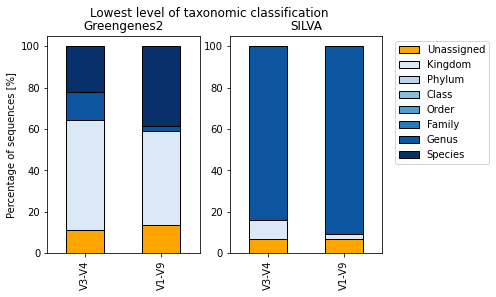

In [10]:
# Plot the number of correct/incorrect classifications for each samples as a stacked barplot
fig, ax = plt.subplots(1, 2)
all_gg_highest_ratio.plot(kind='bar', color=color_levels_nokey, edgecolor='Black', stacked=True, ax=ax[0], legend=False)
ax[0].set_yticklabels(['0', '20', '40', '60', '80', '100'])
ax[0].set_title('Greengenes2')
ax[0].set_ylabel('Percentage of sequences [%]')

all_silva_highest_ratio.plot(kind='bar', color=color_levels_nokey, edgecolor='Black', stacked=True, ax=ax[1])
ax[1].set_yticklabels(['0', '20', '40', '60', '80', '100'])
ax[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax[1].set_title('SILVA')

fig.suptitle('Lowest level of taxonomic classification')

plt.show()

#### Illumina Greengenes2 vs SILVA vs GTDB

In [17]:
# Illumina gg/SILVA/GTDB
illumina_gg_highest = find_class_levels_nokey(illumina_gg)
illumina_silva_highest = find_class_levels_nokey(illumina_silva)
illumina_GTDB_highest = find_class_levels_nokey(illumina_GTDB)

all_illumina_highest = pd.concat([illumina_gg_highest, illumina_silva_highest, illumina_GTDB_highest])
all_illumina_highest.index = samples_databases

all_illumina_highest_ratio = all_illumina_highest.copy(deep=True)
for sample in range(len(samples_databases)):
    all_illumina_highest_ratio.iloc[sample,:] /= all_illumina_highest.iloc[sample,:].sum()
all_illumina_highest_ratio.columns = pd.CategoricalIndex(all_illumina_highest_ratio.columns.values, ordered=True, categories=['Unassigned'] + taxonomic_levels)
all_illumina_highest_ratio = all_illumina_highest_ratio.sort_index(axis=1)

In [18]:
all_illumina_highest_ratio

,Unassigned,Kingdom,Phylum,Class,Order,Family,Genus,Species
Greengenes2,0.200000,0.600000,0,0,0,0,0.111111,0.088889
SILVA,0.400000,0.044444,0,0,0,0,0.555556,0.000000
GTDB,0.222222,0.666667,0,0,0,0,0.066667,0.044444


/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_9766/1711348333.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])


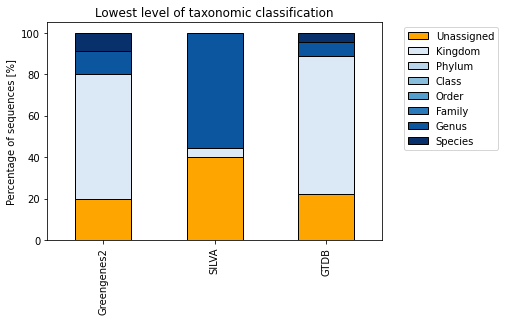

In [31]:
# Plot the number of correct/incorrect classifications for each samples as a stacked barplot
fig, ax = plt.subplots()
all_illumina_highest_ratio.plot(kind='bar', color=color_levels_nokey, edgecolor='Black', stacked=True, ax=ax)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_ylabel('Percentage of sequences [%]')
ax.set_title('Lowest level of taxonomic classification')
plt.show()

### Plot the classification levels with key
Calculate the number of sequences correctly classified at different taxonomic levels, by comparing to a taxonomy key. The sequences must share ID to be compared.

In [11]:
# Find misclassified sequences
def find_misclassified(dataframe, correct_classification, conversion_table):
    '''Takes a dataframe and calculates the number of sequences that have been classified correctly (not NA)
    to the different taxonomical levels by comparing each sequence to its corresponding sequence in the correct
    classification. For incorrectly classified sequences, the program can also look in the conversion table to
    see if it is due to heteronyms, and then label is at correct.
    Input: 
    - Dataframe with sequences (rows, R) and taxonomical classification at different levels (columns, C)
    - Correct classification: The expected taxonomy, in the same format as the input dataframe
    - Conversion table: A dictionary with possible synonyms in the classification that still should be
    considered correct
    Output: A dataframe with an additional column 'Correct' describing if the classification is correct or not,
    and at what taxonomic level'''

    # Create a copy to not mess with the original datafiles
    dataframe_genus_species = dataframe.applymap(lambda x: x.strip() if type(x)==str else x)
    taxonomy_genus_species = correct_classification.applymap(lambda x: x.strip() if type(x)==str else x)

    # Look through all sequences
    for ID in dataframe.index:
        # If the whole species name (genus + species) is the same as the taxonomy, the classification is correct at species level
        if dataframe_genus_species.loc[ID,'Species'] == taxonomy_genus_species.loc[ID,'Species']:
            if dataframe_genus_species.loc[ID,'Genus'] == taxonomy_genus_species.loc[ID,'Genus']:
                correct = 'Species'
        
        # If not correct at species level, loop over all levels to find one at which the taxonomy is correct
        # There there is no level that is correct, it is probably "unassigned"
        # Check if the classification is wrong at the kingdom level
        else:
            for level in reversed(dataframe.columns[:-1]):
                if dataframe_genus_species.loc[ID,level] == taxonomy_genus_species.loc[ID,level]:
                    correct = level
                    break
                else:
                    correct = 'Unassigned'
        
            if dataframe_genus_species.loc[ID, 'Kingdom'] == 'Archaea' or dataframe_genus_species.loc[ID, 'Kingdom'] == 'Eukaryota':
                correct = 'Wrong kingdom'
        
        # If the classification isn't correct at a species level, investigate if this is because of heteronyms
        if correct != 'Species':
            if not pd.isna(dataframe_genus_species.loc[ID,'Species']):
                name = dataframe_genus_species.loc[ID,'Genus'] + ' ' + dataframe_genus_species.loc[ID,'Species']
                tax = taxonomy_genus_species.loc[ID,'Genus'] + ' ' + taxonomy_genus_species.loc[ID,'Species']

                if name in conversion_table.keys():
                    if tax in conversion_table[name]:
                        correct = 'Species'

        # Add a new column with the lowest taxonomic level at which the sequence was correctly classified
        dataframe_genus_species.loc[ID, 'Correct'] = correct

    return dataframe_genus_species

In [12]:
def classification_stats(dataframe):
    '''
    Calculate the number of correctly classified sequences at different taxonomic levels
    '''
    correct_sequences = dataframe['Correct'].value_counts()
    return pd.Series.to_frame(correct_sequences).transpose()

#### V3-V4 vs V1-V9

In [13]:
# Greengenes2
fasta_short_gg_corrected = find_misclassified(fasta_short_gg, taxonomy, conversion_dict)
fasta_long_gg_corrected = find_misclassified(fasta_long_gg, taxonomy, conversion_dict)
fasta_short_gg_stats = classification_stats(fasta_short_gg_corrected)
fasta_long_gg_stats = classification_stats(fasta_long_gg_corrected)

all_gg_stats = pd.concat([fasta_short_gg_stats, fasta_long_gg_stats])
all_gg_stats.index = samples

all_gg_stats_ratio = all_gg_stats.copy(deep=True)
for sample in range(len(samples)):
    all_gg_stats_ratio.iloc[sample,:] /= all_gg_stats.iloc[sample,:].sum()
all_gg_stats_ratio.columns = pd.CategoricalIndex(all_gg_stats_ratio.columns.values, ordered=True, categories=['Wrong kingdom'] + ['Unassigned'] + taxonomic_levels)
all_gg_stats_ratio = all_gg_stats_ratio.sort_index(axis=1)

# SILVA
fasta_short_silva_corrected = find_misclassified(fasta_short_silva, taxonomy, conversion_dict)
fasta_long_silva_corrected = find_misclassified(fasta_long_silva, taxonomy, conversion_dict)
fasta_short_silva_stats = classification_stats(fasta_short_silva_corrected)
fasta_long_silva_stats = classification_stats(fasta_long_silva_corrected)

all_silva_stats = pd.concat([fasta_short_silva_stats, fasta_long_silva_stats])
all_silva_stats.index = samples

all_silva_stats_ratio = all_silva_stats.copy(deep=True)
for sample in range(len(samples)):
    all_silva_stats_ratio.iloc[sample,:] /= all_silva_stats.iloc[sample,:].sum()
all_silva_stats_ratio.columns = pd.CategoricalIndex(all_silva_stats_ratio.columns.values, ordered=True, categories=['Wrong kingdom'] + ['Unassigned'] + taxonomic_levels)
all_silva_stats_ratio = all_silva_stats_ratio.sort_index(axis=1)

In [16]:
all_silva_stats_ratio

,Wrong kingdom,Unassigned,Kingdom,Genus
V3-V4,0.068182,0.068182,0.636364,0.227273
V1-V9,0.045455,0.068182,0.681818,0.204545


/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_8288/90661262.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(['0', '20', '40', '60', '80', '100'])
/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_8288/90661262.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(['0', '20', '40', '60', '80', '100'])


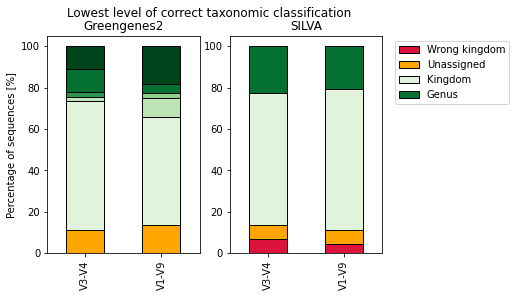

In [30]:
# Plot the number of correct/incorrect classifications for each samples as a stacked barplot
fig, ax = plt.subplots(1, 2)
all_gg_stats_ratio.plot(kind='bar', color=color_levels_key, edgecolor='Black', stacked=True, ax=ax[0], legend=False)
ax[0].set_yticklabels(['0', '20', '40', '60', '80', '100'])
ax[0].set_title('Greengenes2')
ax[0].set_ylabel('Percentage of sequences [%]')

all_silva_stats_ratio.plot(kind='bar', color=color_levels_key, edgecolor='Black', stacked=True, ax=ax[1])
ax[1].set_yticklabels(['0', '20', '40', '60', '80', '100'])
ax[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax[1].set_title('SILVA')

fig.suptitle('Lowest level of correct taxonomic classification')

plt.show()

#### Illumina Greengenes2 vs SILVA vs GTDB

In [28]:
# 
illumina_gg_correct = find_misclassified(illumina_gg, taxonomy, conversion_dict)
illumina_silva = find_misclassified(illumina_silva, taxonomy, conversion_dict)
illumina_GTDB = find_misclassified(illumina_GTDB, taxonomy, conversion_dict)

illumina_gg_stats = classification_stats(illumina_gg_correct)
illumina_silva_stats = classification_stats(illumina_silva)
illumina_GTDB_stats = classification_stats(illumina_GTDB)

all_databases_stats = pd.concat([illumina_gg_stats, illumina_silva_stats, illumina_GTDB_stats])
all_databases_stats.index = samples_databases

all_databases_stats_ratio = all_databases_stats.copy(deep=True)
for sample in range(len(samples_databases)):
    all_databases_stats_ratio.iloc[sample,:] /= all_databases_stats.iloc[sample,:].sum()
all_databases_stats_ratio.columns = pd.CategoricalIndex(all_databases_stats_ratio.columns.values, ordered=True, categories=['Wrong kingdom'] + ['Unassigned'] + taxonomic_levels)
all_databases_stats_ratio = all_databases_stats_ratio.sort_index(axis=1)

/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_9766/708430881.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])


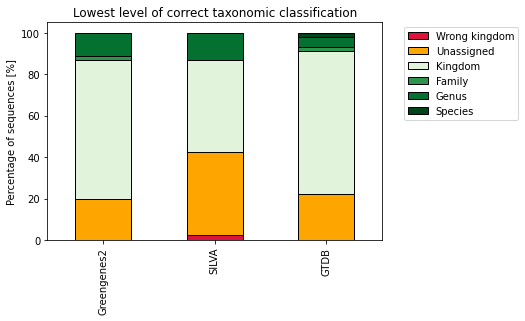

In [32]:
# Plot the number of correct/incorrect classifications for each samples as a stacked barplot
fig, ax = plt.subplots()
all_databases_stats_ratio.plot(kind='bar', color=color_levels_key, edgecolor='Black', stacked=True, ax=ax)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_ylabel('Percentage of sequences [%]')
ax.set_title('Lowest level of correct taxonomic classification')
plt.show()